In [7]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
def get_data_loaders(batch_size=128, num_workers=0):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    trainset = torchvision.datasets.MNIST(root='./data',
                                          train=True,
                                          download=True,
                                          transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers)

    testset = torchvision.datasets.MNIST(root='./data',
                                         train=False,
                                         download=True,
                                         transform=transform)

    testloader = torch.utils.data.DataLoader(testset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=num_workers)

    return trainloader, testloader


def generate_plot_accuracies(mode, accuracies, title, save_path):
    if mode == 'oneshot':
        accuracies = list(map(list, zip(*accuracies)))

    fig, ax = plt.subplots()
    for idx, acc in enumerate(accuracies):
        ax.plot(acc, '-s', label=f'Subnet {idx+1}')
    ax.grid()
    ax.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    fig.savefig(save_path)
    plt.show()


def generate_accuracy_table(oneshot_acc, standalone_acc, output_path):
    index = [f"Subnet {subnet + 1}" for subnet in range(len(standalone_acc))]
    data = {
        "SUBNET": index,
        "ONESHOT": [],
        "STANDALONE": []
    }
    oneshot_acc = list(map(list, zip(*oneshot_acc)))
    print('here')
    for i in range(len(oneshot_acc)):
        data["ONESHOT"].append(max(oneshot_acc[i]))
        data["STANDALONE"].append(max(standalone_acc[i]))

    df = pd.DataFrame(data)

    plt.figure(figsize=(7, 3))
    plt.axis('off')
    table = plt.table(cellText=df.values,
                      colLabels=df.columns,
                      cellLoc='center',
                      loc='center',
                      colColours=['lightgray'] * len(df.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    plt.title("OneShot-vs-Standalone Accuracy Table", fontsize=14)

    plt.savefig(output_path)


In [3]:
class NASBlock(nn.Module):
    def __init__(self, num_channels, num_stages=1):
        super(NASBlock, self).__init__()
        layers = [nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
                  nn.BatchNorm2d(num_channels),
                  nn.ReLU()]
        for _ in range(num_stages - 1):
            layers += [nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
                       nn.BatchNorm2d(num_channels),
                       nn.ReLU()]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class SuperNet(nn.Module):
    def __init__(self,
                 input_channels=1,
                 num_classes=10,
                 block_num_stages=(1, 2, 3)):
        super(SuperNet, self).__init__()

        self.conv = nn.Sequential(
                nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True))

        self.nasblock1_choice = None
        self.nas_block1_variants = nn.ModuleList(
            [NASBlock(num_channels=64, num_stages=num_stages) for num_stages in block_num_stages])

        self.conv_stride = nn.Sequential(
                nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True))

        self.nasblock2_choice = None
        self.nas_block2_variants = nn.ModuleList(
            [NASBlock(num_channels=32, num_stages=num_stages) for num_stages in block_num_stages])

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.nas_block1_variants[self.nasblock1_choice](x)
        x = self.conv_stride(x)
        x = self.nas_block2_variants[self.nasblock2_choice](x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def sample_subnet(self, num_stages_nasblock1=None, num_stages_nasblock2=None):
        self.nasblock1_choice = num_stages_nasblock1 if num_stages_nasblock1 is not None \
            else torch.randint(0, 3, size=(1,)).item()
        self.nasblock2_choice = num_stages_nasblock2 if num_stages_nasblock2 is not None \
            else torch.randint(0, 3, size=(1,)).item()


In [4]:
def train(model, device, train_loader, optimizer, epoch, loss_func, subnet=None):
    model.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        if subnet is None:
            model.sample_subnet()
        else:
            model.sample_subnet(*subnet)

        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} ({:.0f}%)\tLoss: {:.6f}'.format(
                epoch, 100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, loss_func, subnet):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += loss_func(output, label, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Testing Subnet {}, Accuracy: {}/{} ({:.0f}%)'.format(
        subnet, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


def train_test(supernet, epochs=20, subnet=None):

    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader = get_data_loaders()

    test_acc = []

    if subnet is None:
        model = supernet.to(device)
    else:
        supernet.sample_subnet(*subnet)
        model = supernet.to(device)

    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    loss_func = F.cross_entropy

    if subnet is None:
        for epoch in range(1, epochs + 1):
            train(model, device, train_loader, optimizer, epoch, loss_func)

            test_acc_ = []
            for subnet in [(x, y) for x in range(3) for y in range(3)]:
                model.sample_subnet(*subnet)
                test_acc_.append(test(model, device, test_loader, loss_func, subnet))
            test_acc.append(test_acc_)

    else:
        for epoch in range(1, epochs + 1):
            train(model, device, train_loader, optimizer, epoch, loss_func, subnet=subnet)
            test_acc.append(test(model, device, test_loader, loss_func, subnet))

    return test_acc


In [8]:
epochs = 20

In [9]:
print('Training and testing oneshot subnets...')
one_shot_nas_accuracies = train_test(SuperNet(), epochs)

Training and testing oneshot subnets...
Train Epoch: 1 (0%)	Loss: 2.325038
Train Epoch: 1 (21%)	Loss: 1.487324
Train Epoch: 1 (43%)	Loss: 0.389989
Train Epoch: 1 (64%)	Loss: 0.316136
Train Epoch: 1 (85%)	Loss: 0.200247
Testing Subnet (0, 0), Accuracy: 4630/10000 (46%)
Testing Subnet (0, 1), Accuracy: 5949/10000 (59%)
Testing Subnet (0, 2), Accuracy: 6549/10000 (65%)
Testing Subnet (1, 0), Accuracy: 8416/10000 (84%)
Testing Subnet (1, 1), Accuracy: 9017/10000 (90%)
Testing Subnet (1, 2), Accuracy: 8643/10000 (86%)
Testing Subnet (2, 0), Accuracy: 8277/10000 (83%)
Testing Subnet (2, 1), Accuracy: 8267/10000 (83%)
Testing Subnet (2, 2), Accuracy: 8814/10000 (88%)
Train Epoch: 2 (0%)	Loss: 0.148130
Train Epoch: 2 (21%)	Loss: 0.066922
Train Epoch: 2 (43%)	Loss: 0.318229
Train Epoch: 2 (64%)	Loss: 0.059588
Train Epoch: 2 (85%)	Loss: 0.071431
Testing Subnet (0, 0), Accuracy: 5780/10000 (58%)
Testing Subnet (0, 1), Accuracy: 6600/10000 (66%)
Testing Subnet (0, 2), Accuracy: 8493/10000 (85%)
Te

In [10]:
print('Training and testing standalone subnets...')
standalone_accuracies = []
for subnet in [(x, y) for x in range(3) for y in range(3)]:
    supernet = SuperNet()
    standalone_accuracies.append(train_test(supernet, epochs, subnet=subnet))

Training and testing standalone subnets...
Train Epoch: 1 (0%)	Loss: 2.343431
Train Epoch: 1 (21%)	Loss: 0.358891
Train Epoch: 1 (43%)	Loss: 0.156246
Train Epoch: 1 (64%)	Loss: 0.180029
Train Epoch: 1 (85%)	Loss: 0.076162
Testing Subnet (0, 0), Accuracy: 9461/10000 (95%)
Train Epoch: 2 (0%)	Loss: 0.108857
Train Epoch: 2 (21%)	Loss: 0.067800
Train Epoch: 2 (43%)	Loss: 0.072993
Train Epoch: 2 (64%)	Loss: 0.059739
Train Epoch: 2 (85%)	Loss: 0.054350
Testing Subnet (0, 0), Accuracy: 9649/10000 (96%)
Train Epoch: 3 (0%)	Loss: 0.068840
Train Epoch: 3 (21%)	Loss: 0.029883
Train Epoch: 3 (43%)	Loss: 0.023739
Train Epoch: 3 (64%)	Loss: 0.065259
Train Epoch: 3 (85%)	Loss: 0.040458
Testing Subnet (0, 0), Accuracy: 9474/10000 (95%)
Train Epoch: 4 (0%)	Loss: 0.068985
Train Epoch: 4 (21%)	Loss: 0.030935
Train Epoch: 4 (43%)	Loss: 0.057838
Train Epoch: 4 (64%)	Loss: 0.010686
Train Epoch: 4 (85%)	Loss: 0.039436
Testing Subnet (0, 0), Accuracy: 9778/10000 (98%)
Train Epoch: 5 (0%)	Loss: 0.033001
Train 

Generating oneshot subnets accuracies plot...


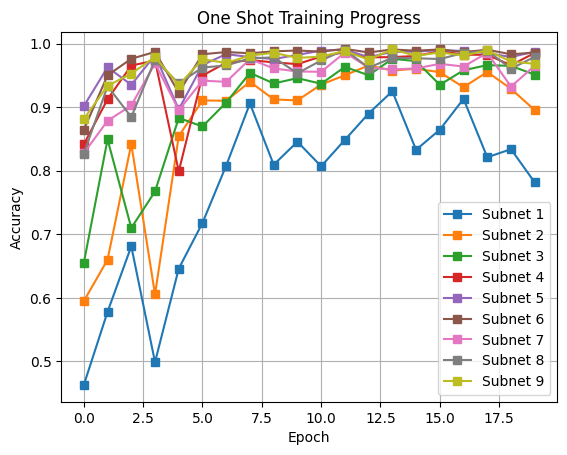

In [12]:
print('Generating oneshot subnets accuracies plot...')
generate_plot_accuracies('oneshot', one_shot_nas_accuracies,
                         'One Shot Training Progress',
                         '/content/pics/one-shot-subnets.png')

Generating standalone subnets accuracies plot...


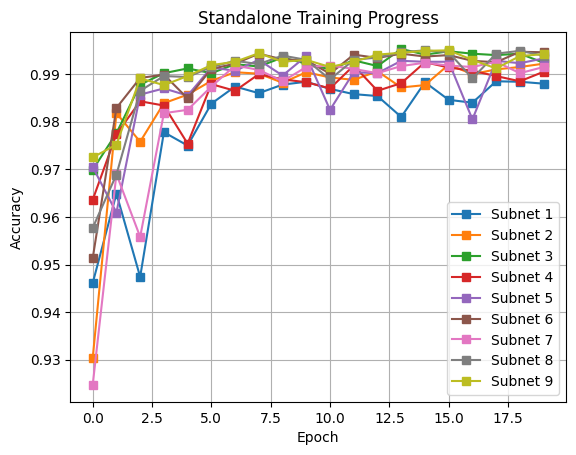

In [13]:
print('Generating standalone subnets accuracies plot...')
generate_plot_accuracies('standalone', standalone_accuracies,
                         'Standalone Training Progress',
                         '/content/pics/standalone-subnets.png')

Generating oneshot-vs-standalone subnets top-1 accuracies table...
here


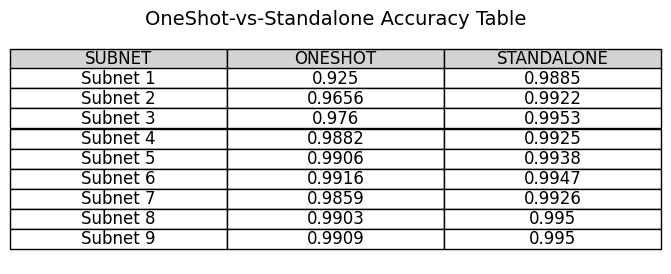

In [28]:
print('Generating oneshot-vs-standalone subnets top-1 accuracies table...')
generate_accuracy_table(one_shot_nas_accuracies,
                        standalone_accuracies,
                        '/content/pics/oneshot_vs_standalone_table.png')